In [16]:
from __future__ import print_function    # (at top of module)
import warnings
#warnings.filterwarnings('always')
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]
from matplotlib.pyplot import figure
import math
import seaborn as sns
import io, os, sys, types

In [17]:
# Read the data from the file
data = pd.read_csv('Data/data_500_entries_youtube.csv')
print("Number of entries in original data: " + str(len(data.index)))
data.head()

Number of entries in original data: 570


,song_id,song_title,artist,popularity,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,youtube_view_count,youtube_video_title
0,spotify:track:5ygDXis42ncn6kYG14lEVG,Baby Shark,[Pinkfong],77,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,1956582159,Baby Shark Dance | Sing and Dance! | Animal So...
1,spotify:track:7fa9MBXhVfQ8P8Df9OEbD8,Girls Like You (feat. Cardi B),"[Maroon 5, Cardi B]",86,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,1300452389,Maroon 5 - Girls Like You ft. Cardi B
2,spotify:track:6De0lHrwBfPfrhorm9q1Xl,Me Rehúso,[Danny Ocean],83,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,1229501096,Danny Ocean - Me Rehúso (Official Audio)
3,spotify:track:1j6xOGusnyXq3l6IryKF3G,Déjala Que Vuelva (feat. Manuel Turizo),"[Piso 21, Manuel Turizo]",74,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,1216075058,Piso 21 - Déjala Que Vuelva (feat. Manuel Turi...
4,spotify:track:2ijef6ni2amuunRoKTlgww,Sin Pijama,"[Becky G, Natti Natasha]",90,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,1071141995,Becky G Natti Natasha - Sin Pijama (Video Ofic...


In [18]:
if 'song_id' in data.columns:
    data = data.drop_duplicates(subset=['song_id'], keep='first')
else:
    data = data.drop_duplicates(subset=['song_title'], keep='first')
    
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [19]:
data = data[data.popularity > 50]
print("Number of entries in original data after cleaning: " + str(len(data.index)))

Number of entries in original data after cleaning: 570


In [20]:
from project_modules import *

final_data = label_data(data, 90)

Number of popular examples after thresholding :  47
Number of not popular examples after thresholding :  523


In [21]:
# Drop unnecessary columns from original data - also some legacy support for a different data format
if 'song_id' in data.columns:
    final_data.drop(['song_id', 'song_title', 'artist', 'popularity', 'youtube_video_title', 'youtube_view_count'], 1, inplace=True)
else:
    final_data.drop(['song_title', 'artist', 'popularity'], 1, inplace=True) 

In [22]:
final_data.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,is_popular
0,0.840,0.3410,115.062,0.2270,0.2450,0.000000,4,0.825,7,96333,-3.651,0.520,1,0
1,0.541,0.1300,124.959,0.0505,0.5680,0.000000,4,0.851,0,235545,-6.825,0.448,1,0
2,0.804,0.0494,104.823,0.0677,0.0231,0.000000,4,0.744,1,205715,-6.327,0.426,1,0
3,0.788,0.0753,170.019,0.0785,0.0482,0.000000,4,0.681,1,220117,-4.323,0.839,1,0
4,0.745,0.1040,94.014,0.0464,0.3540,0.000029,4,0.791,11,188560,-3.695,0.820,0,0


In [23]:
COLUMNS_TO_SCALE = ["energy", "liveness", "tempo", 
                    "speechiness", "acousticness", "instrumentalness", 
                    "time_signature", "danceability", "key", 
                    "duration", "loudness", "valence", "mode"]
#COLUMNS_TO_SCALE = ["energy", "tempo","loudness", "valence"]

# Keep data in a temp variable for testing
scaled_data = scale_data_standardize(final_data, COLUMNS_TO_SCALE)

# Plots to see the difference before/after scaling
# plt.subplot(1,2,1)
# plt.plot(data['duration'])
# plt.title("Duration before scaling")

# plt.subplot(1,2,2)
# plt.plot(scaled_data['duration'])
# plt.title("Duration after scaling")
# plt.tight_layout()
# plt.show()

# Copy data back
final_data = scaled_data.copy()

#Just to check that everything is fine
final_data.head()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration,loudness,valence,mode,is_popular
0,1.134405,1.053202,-0.263119,0.898741,-0.028242,-0.144642,0.060474,0.935711,0.496241,-2.711681,1.099652,-0.006954,0.862044,0
1,-0.725307,-0.307878,0.073383,-0.747680,1.378645,-0.144642,0.060474,1.133659,-1.458350,0.839454,-0.346005,-0.342110,0.862044,0
2,0.910493,-0.827797,-0.611250,-0.587236,-0.994769,-0.144642,0.060474,0.319027,-1.179123,0.078526,-0.119182,-0.444518,0.862044,0
3,0.810977,-0.660726,1.605444,-0.486492,-0.885441,-0.144642,0.060474,-0.160616,-1.179123,0.445904,0.793577,1.477973,0.862044,0
4,0.543526,-0.475594,-0.978761,-0.785926,0.446528,-0.144238,0.060474,0.676856,1.613150,-0.359078,1.079611,1.389529,-1.160034,0


In [24]:
# X will be our examples and y will be our labels
X = final_data.drop('is_popular', axis=1)
y = final_data['is_popular']
# Sanity checks
print("Number of entries in actual data: " + str(len(X.index)))
print("Number of entries in label data: " + str(len(y.index)))

Number of entries in actual data: 570
Number of entries in label data: 570


In [25]:
# We split the data into training and testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=5)
print("Items in training data set : ", str(len(X_train.index)))
print("Items in testing data set: ", str(len(X_test.index)))

Items in training data set :  285
Items in testing data set:  285


In [29]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

models = [
          {'title':"Logistic regression", 'model':LogisticRegression(random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'key', 'duration']},
          {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3), 'feature_set':['tempo', 'acousticness', 'danceability', 'valence']},
          {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
          {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
          {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability']},
          {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':['energy', 'instrumentalness', 'duration', 'valence', 'mode']},
          {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':'all'},
          {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':'all'},
          {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':'all'},
          {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':'all'},
          {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':'all'},
          {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':'all'}
         ]
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC"]

# Train-test split

Logistic regression

Accuracy:  0.936842105263

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[267   1]
 [ 17   0]]


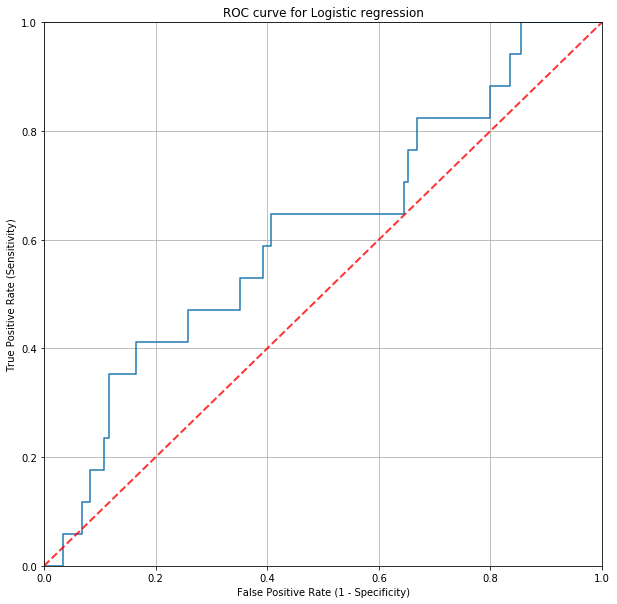

AUC score:  0.614793678665

Logistic regression balanced weights

Accuracy:  0.649122807018

              precision    recall  f1-score   support

           0       0.95      0.66      0.78       268
           1       0.07      0.41      0.12        17

   micro avg       0.65      0.65      0.65       285
   macro avg       0.51      0.54      0.45       285
weighted avg       0.89      0.65      0.74       285

Confusion matrix: 
[[178  90]
 [ 10   7]]


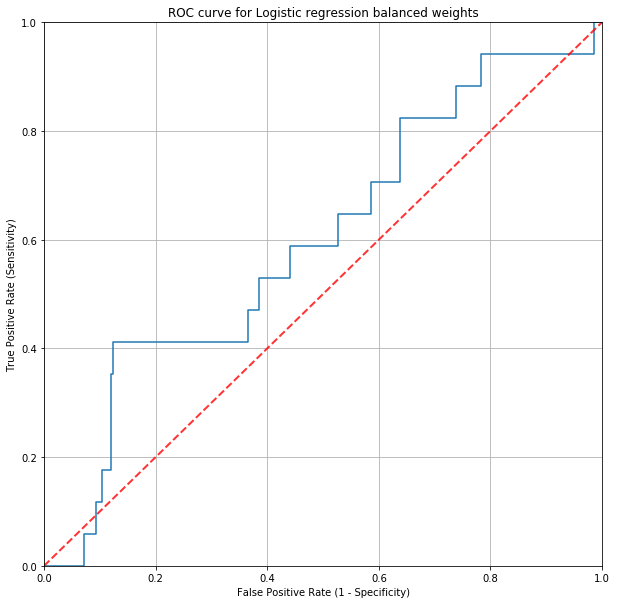

AUC score:  0.597892888499

Oversampling logistic regression

Accuracy:  0.617543859649

              precision    recall  f1-score   support

           0       0.94      0.63      0.76       268
           1       0.07      0.41      0.11        17

   micro avg       0.62      0.62      0.62       285
   macro avg       0.51      0.52      0.43       285
weighted avg       0.89      0.62      0.72       285

Confusion matrix: 
[[169  99]
 [ 10   7]]


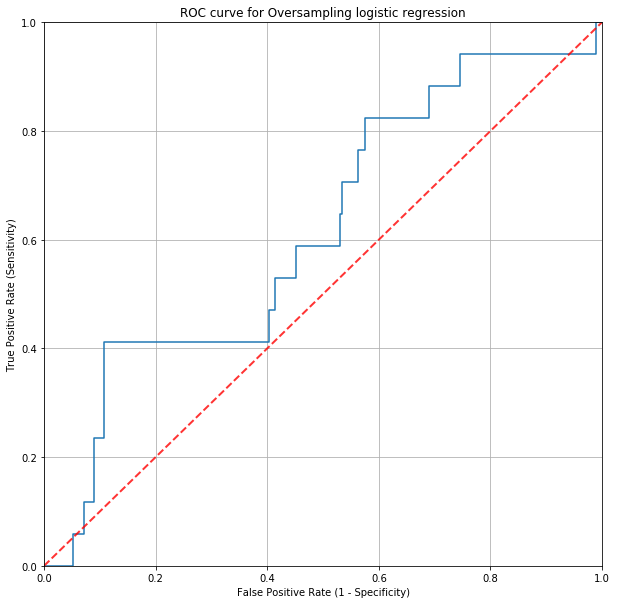

AUC score:  0.616330114135

Oversampling logistic regression balanced weights

Accuracy:  0.617543859649

              precision    recall  f1-score   support

           0       0.94      0.63      0.76       268
           1       0.07      0.41      0.11        17

   micro avg       0.62      0.62      0.62       285
   macro avg       0.51      0.52      0.43       285
weighted avg       0.89      0.62      0.72       285

Confusion matrix: 
[[169  99]
 [ 10   7]]


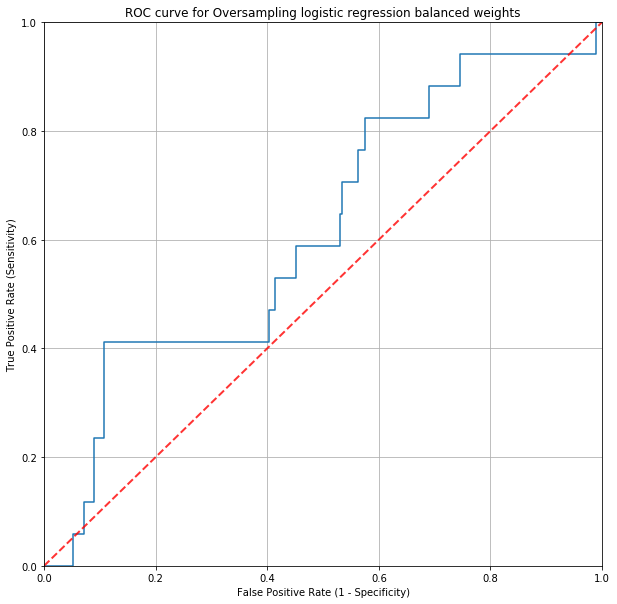

AUC score:  0.616330114135

KNN

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


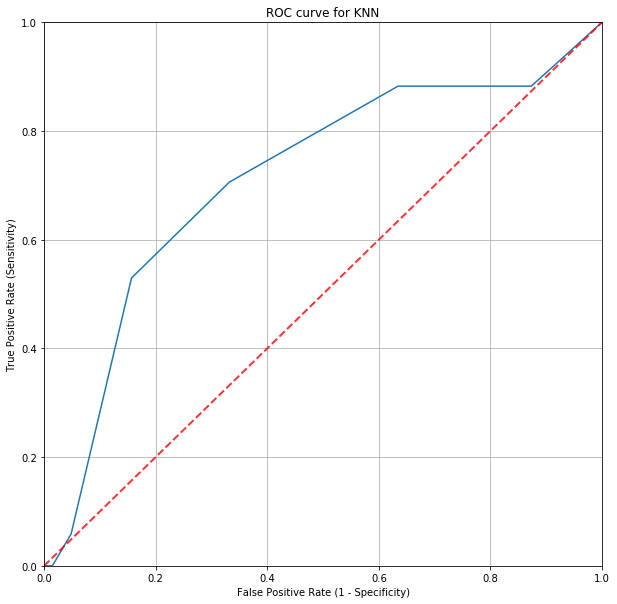

AUC score:  0.711259877085

Oversampling KNN

Accuracy:  0.463157894737

              precision    recall  f1-score   support

           0       0.98      0.44      0.60       268
           1       0.09      0.88      0.16        17

   micro avg       0.46      0.46      0.46       285
   macro avg       0.54      0.66      0.38       285
weighted avg       0.93      0.46      0.58       285

Confusion matrix: 
[[117 151]
 [  2  15]]


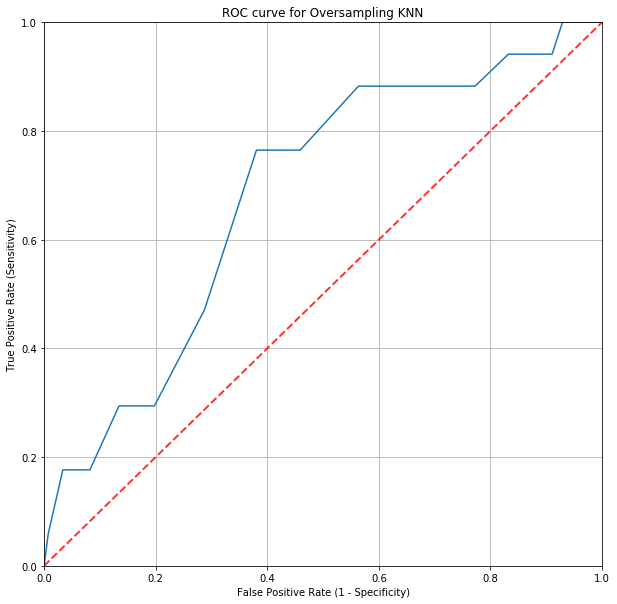

AUC score:  0.682177348551

SVM

Accuracy:  0.940350877193

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       268
           1       0.00      0.00      0.00        17

   micro avg       0.94      0.94      0.94       285
   macro avg       0.47      0.50      0.48       285
weighted avg       0.88      0.94      0.91       285

Confusion matrix: 
[[268   0]
 [ 17   0]]


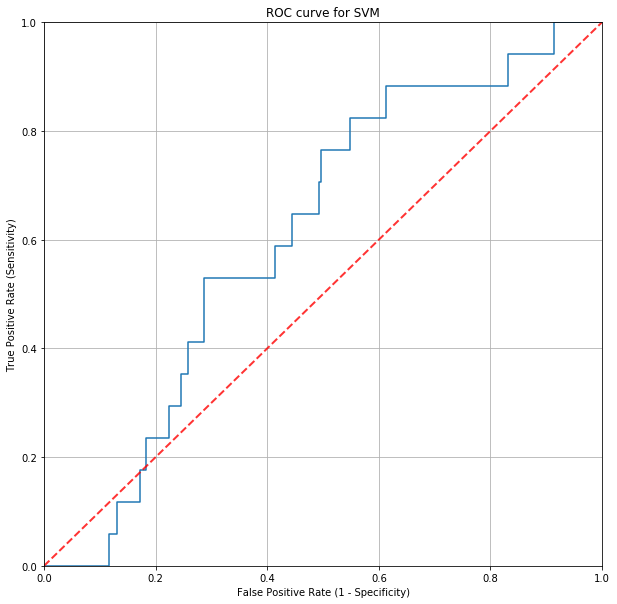

AUC score:  0.608428446005

SVM balanced weights

Accuracy:  0.764912280702

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       268
           1       0.13      0.53      0.21        17

   micro avg       0.76      0.76      0.76       285
   macro avg       0.55      0.65      0.54       285
weighted avg       0.91      0.76      0.82       285

Confusion matrix: 
[[209  59]
 [  8   9]]


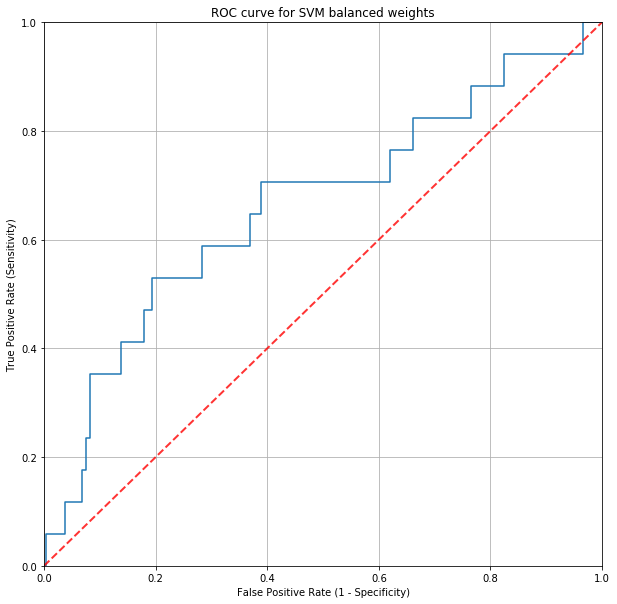

AUC score:  0.662642669008

Oversampling SVM

Accuracy:  0.817543859649

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       268
           1       0.14      0.41      0.21        17

   micro avg       0.82      0.82      0.82       285
   macro avg       0.55      0.63      0.55       285
weighted avg       0.91      0.82      0.86       285

Confusion matrix: 
[[226  42]
 [ 10   7]]


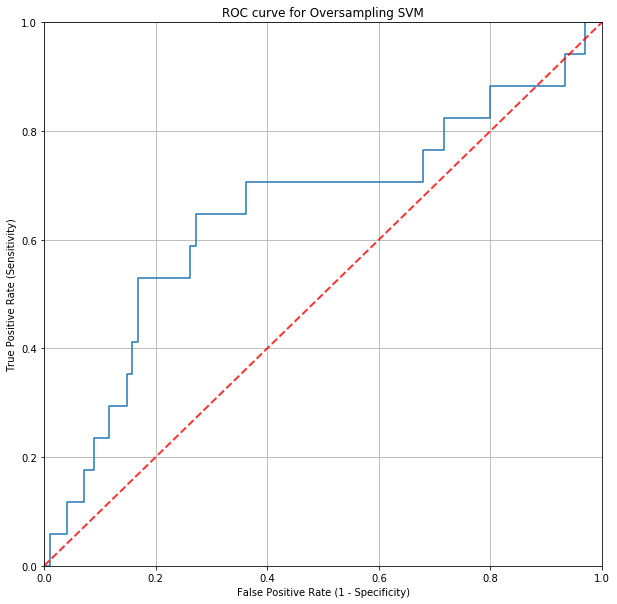

AUC score:  0.649253731343

Multilayer Perceptron

Accuracy:  0.929824561404

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       268
           1       0.00      0.00      0.00        17

   micro avg       0.93      0.93      0.93       285
   macro avg       0.47      0.49      0.48       285
weighted avg       0.88      0.93      0.91       285

Confusion matrix: 
[[265   3]
 [ 17   0]]


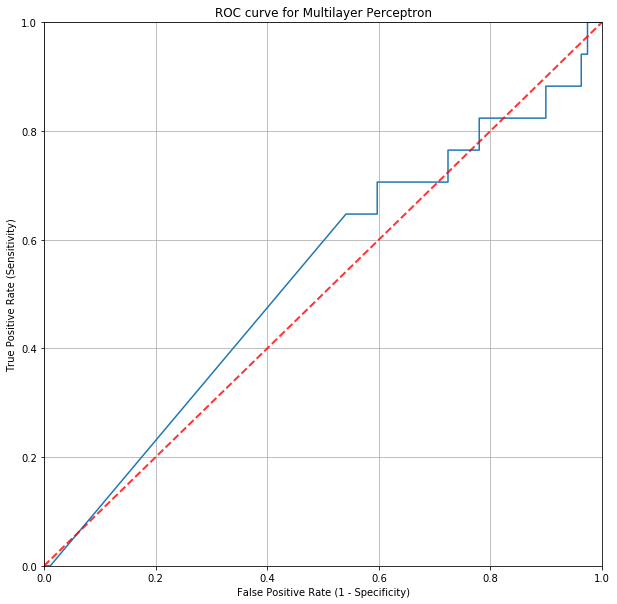

AUC score:  0.530948200176

Oversampling Multilayer Perceptron

Accuracy:  0.814035087719

              precision    recall  f1-score   support

           0       0.95      0.85      0.90       268
           1       0.09      0.24      0.13        17

   micro avg       0.81      0.81      0.81       285
   macro avg       0.52      0.54      0.51       285
weighted avg       0.90      0.81      0.85       285

Confusion matrix: 
[[228  40]
 [ 13   4]]


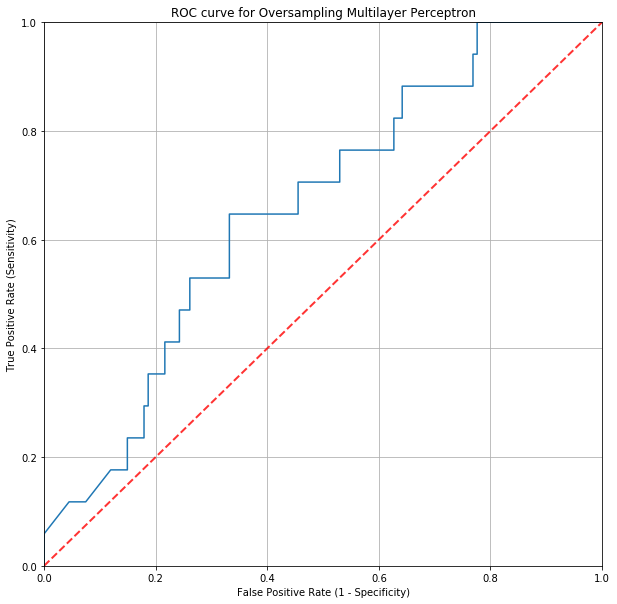

AUC score:  0.657813871817

Random Forest Classifier balanced weights

Accuracy:  0.782456140351

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       268
           1       0.08      0.24      0.11        17

   micro avg       0.78      0.78      0.78       285
   macro avg       0.51      0.53      0.50       285
weighted avg       0.89      0.78      0.83       285

Confusion matrix: 
[[219  49]
 [ 13   4]]


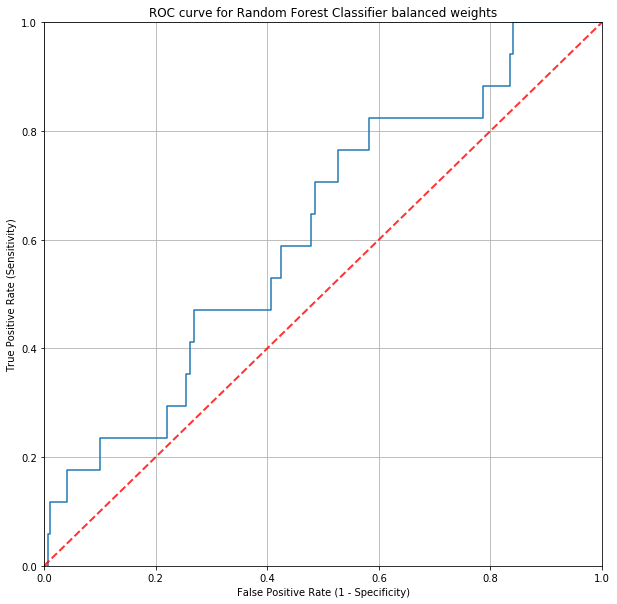

AUC score:  0.615891132572



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC
0,Logistic regression,0.936842,0.996269,0.000000,0.000000,0.909687,0.614794
1,Logistic regression balanced weights,0.649123,0.664179,0.411765,0.072165,0.741459,0.597893
2,Oversampling logistic regression,0.617544,0.630597,0.411765,0.066038,0.717838,0.616330
3,Oversampling logistic regression balanced weights,0.617544,0.630597,0.411765,0.066038,0.717838,0.616330
4,KNN,0.940351,1.000000,0.000000,0.000000,0.911443,0.711260
5,Oversampling KNN,0.463158,0.436567,0.882353,0.090361,0.578363,0.682177
6,SVM,0.940351,1.000000,0.000000,0.000000,0.911443,0.608428
7,SVM balanced weights,0.764912,0.779851,0.529412,0.132353,0.823078,0.662643
8,Oversampling SVM,0.817544,0.843284,0.411765,0.142857,0.855983,0.649254
9,Multilayer Perceptron,0.929825,0.988806,0.000000,0.000000,0.906156,0.530948


In [27]:
stats = []
for item in models:
    # Train-test split
    print(item['title'])
    
    # Train the model
    item['model'].fit(X_train, y_train)

    # Classifiy test examples
    predictions = item['model'].predict(X_test)
    print()

    # Print the accuracy score of the model
    print("Accuracy: ", accuracy_score(y_test, predictions))

    print()

    # Print the classification report of the model
    print(classification_report(y_test, predictions))

    # Print the confusion matrix
    
    print("Confusion matrix: ")
    conf_matrix = confusion_matrix(y_test, predictions)
    print(conf_matrix)
    
    # ROC curve
    y_pred_prob = item['model'].predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr)
    plt.plot([0,0],[1,1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)
    plt.title('ROC curve for ' + item['title'])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.grid(True)
    plt.show()

    # AUC score
    print("AUC score: ", roc_auc_score(y_test, y_pred_prob))
    
    print()
    
    accuracy = accuracy_score(y_test, predictions)
    specificity = float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='weighted')
    auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],accuracy, specificity, recall, precision, f1, auc]
    stats.append(newRow)
stats_df = pd.DataFrame(stats, columns = stats_columns)
stats_df

# 10 Fold Cross Validation

Logistic regression


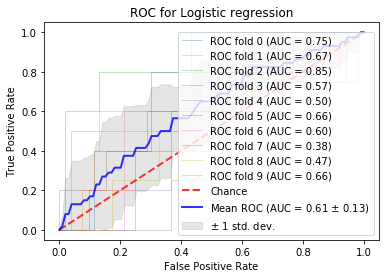

Accuracy mean:  0.915835926022

Logistic regression balanced weights


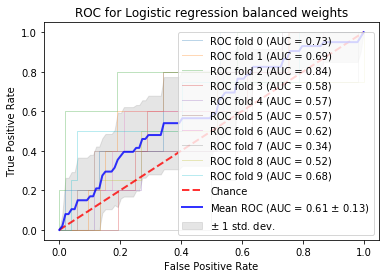

Accuracy mean:  0.615442701582

Oversampling logistic regression


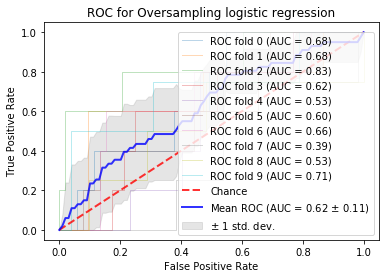

Accuracy mean:  0.640284979691

Oversampling logistic regression balanced weights


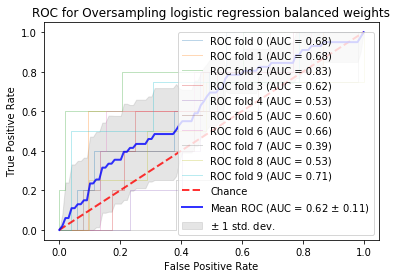

Accuracy mean:  0.640284979691

KNN


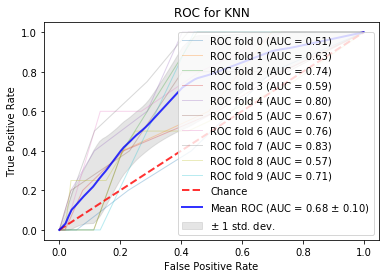

Accuracy mean:  0.917621640308

Oversampling KNN


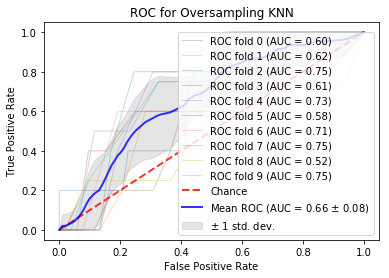

Accuracy mean:  0.543684642641

SVM


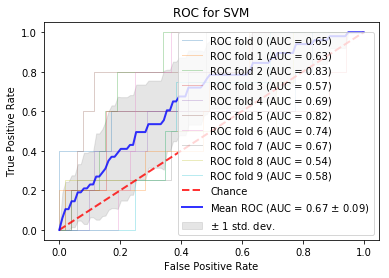

Accuracy mean:  0.917621640308

SVM balanced weights


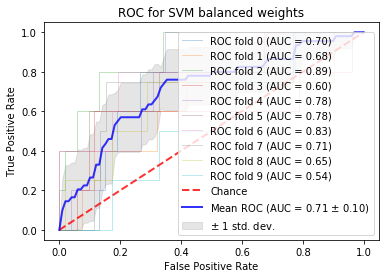

Accuracy mean:  0.753908478092

Oversampling SVM


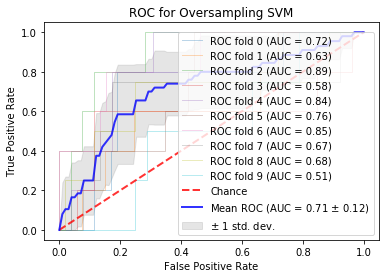

Accuracy mean:  0.822617967332

Multilayer Perceptron


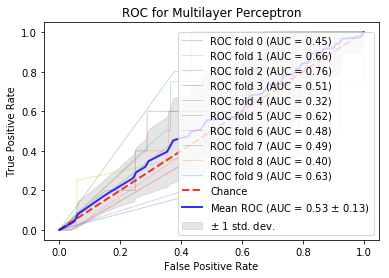

Accuracy mean:  0.910541439806

Oversampling Multilayer Perceptron


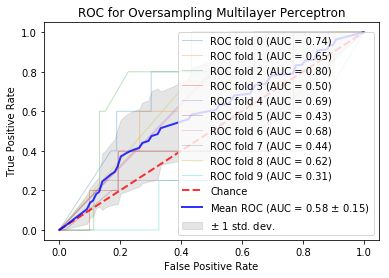

Accuracy mean:  0.698014432633

Random Forest Classifier balanced weights


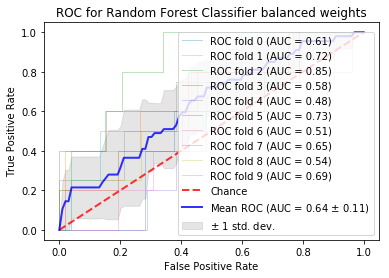

Accuracy mean:  0.759175957134



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC
0,Logistic regression,0.915836,0.998077,0.000,0.000000,0.877317,0.612071
1,Logistic regression balanced weights,0.615443,0.619376,0.565,0.123448,0.700013,0.613283
2,Oversampling logistic regression,0.640285,0.650073,0.525,0.122304,0.720101,0.623182
3,Oversampling logistic regression balanced weights,0.640285,0.650073,0.525,0.122304,0.720101,0.623182
4,KNN,0.917622,1.000000,0.000,0.000000,0.878217,0.681186
5,Oversampling KNN,0.543685,0.527540,0.725,0.120658,0.639597,0.660552
6,SVM,0.917622,1.000000,0.000,0.000000,0.878217,0.670606
7,SVM balanced weights,0.753908,0.766473,0.610,0.202894,0.804408,0.713737
8,Oversampling SVM,0.822618,0.856531,0.440,0.226126,0.848202,0.713182
9,Multilayer Perceptron,0.910541,0.990385,0.025,0.025000,0.876301,0.530845


In [13]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
X = np.array(X)
y = np.array(y)
cv = StratifiedKFold(n_splits=10)
cv_stats = []
for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        predicts = classifier.predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y[test], predicts)
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        accs.append(accuracy_score(y[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y[test], predicts))
        precisions.append(precision_score(y[test], predicts))
        f1s.append(f1_score(y[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df

# 10CV - Done right?

Logistic regression


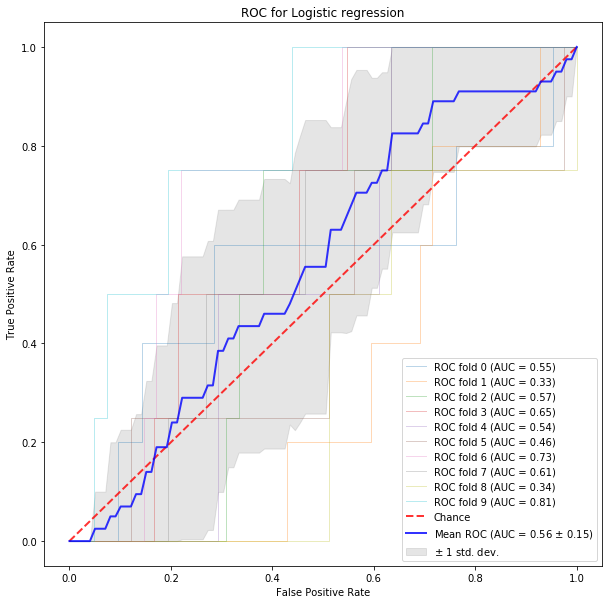

Accuracy mean:  0.907998766574

Logistic regression balanced weights


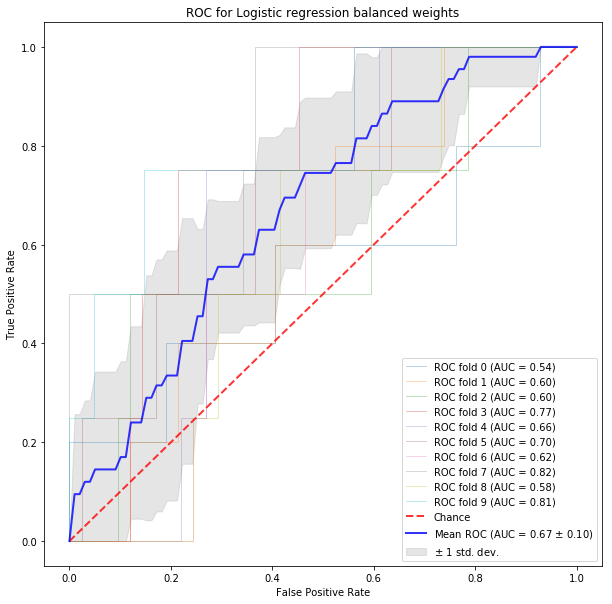

Accuracy mean:  0.609966080789

Oversampling logistic regression


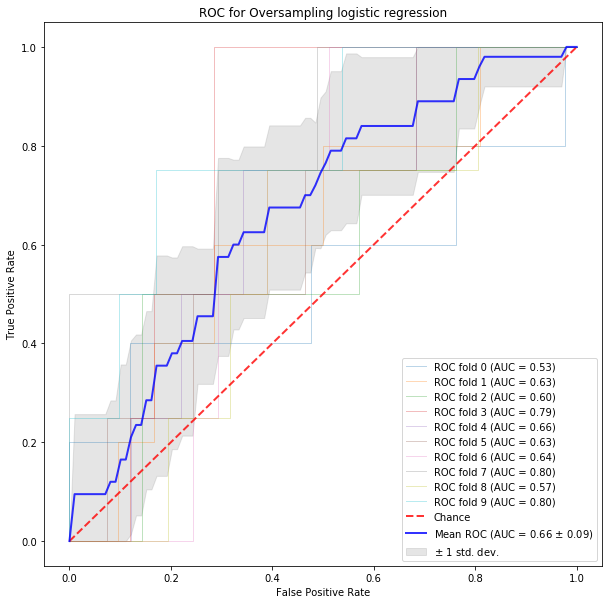

Accuracy mean:  0.649155103299

Oversampling logistic regression balanced weights


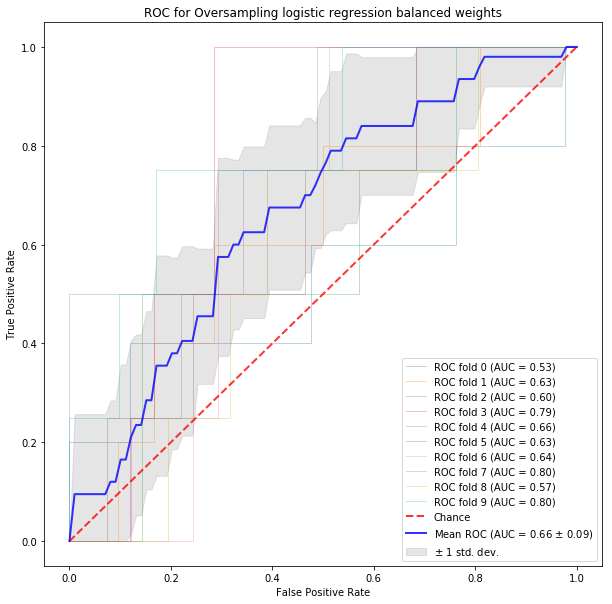

Accuracy mean:  0.649155103299

KNN


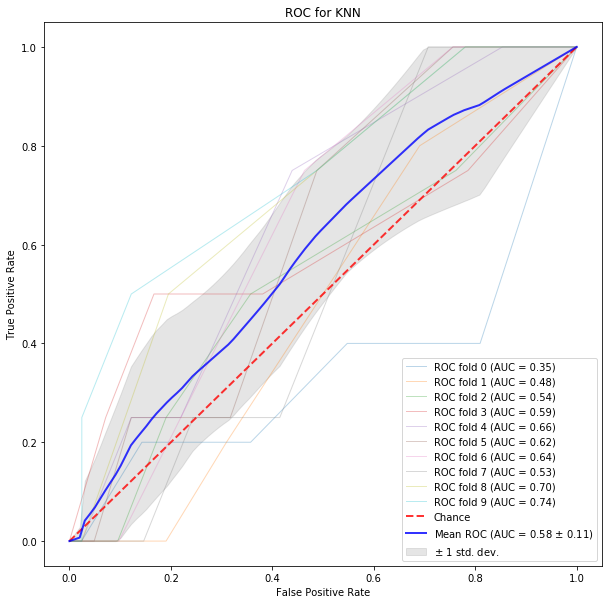

Accuracy mean:  0.907998766574

Oversampling KNN


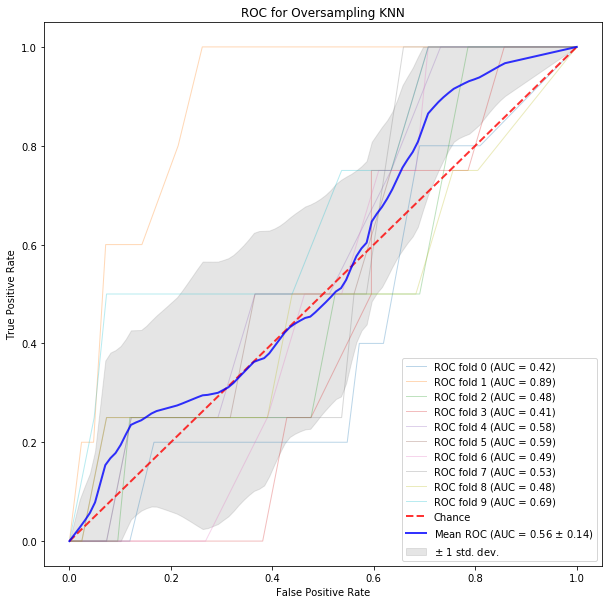

Accuracy mean:  0.575832048515

SVM


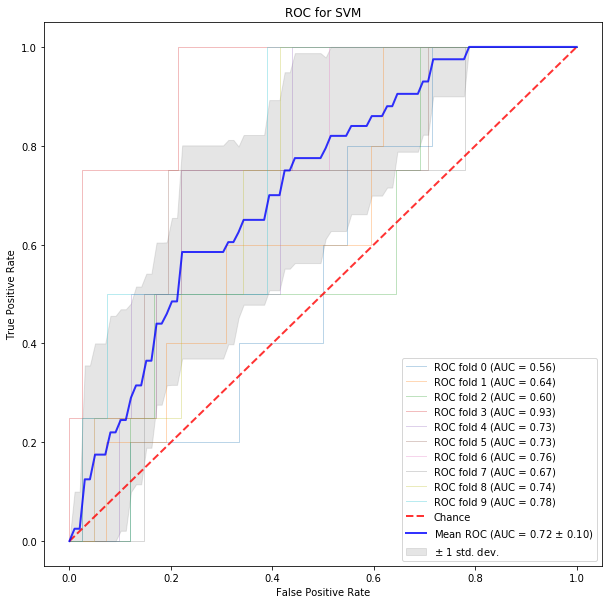

Accuracy mean:  0.907998766574

SVM balanced weights


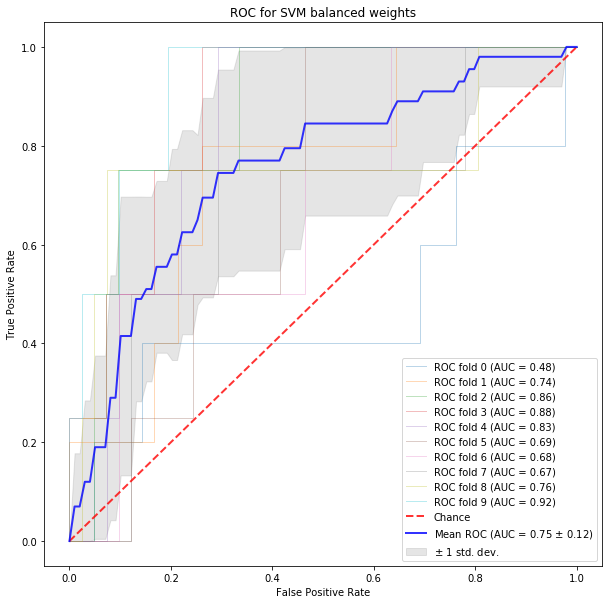

Accuracy mean:  0.752265392127

Oversampling SVM


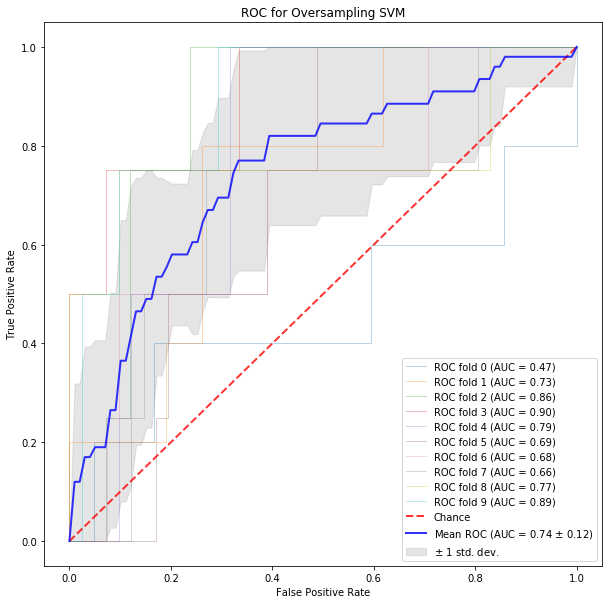

Accuracy mean:  0.811693904821

Multilayer Perceptron


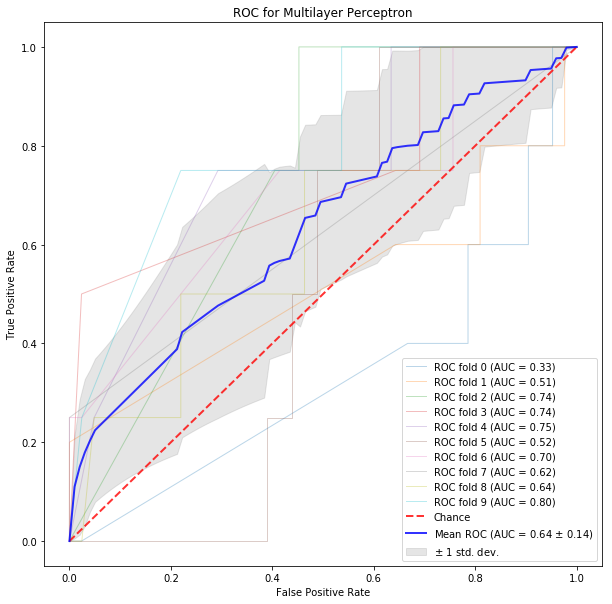

Accuracy mean:  0.905633672525

Oversampling Multilayer Perceptron


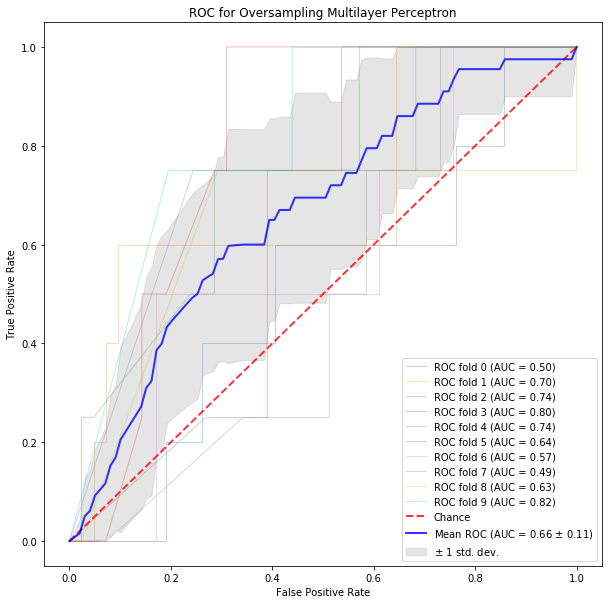

Accuracy mean:  0.738654537979

Random Forest Classifier balanced weights


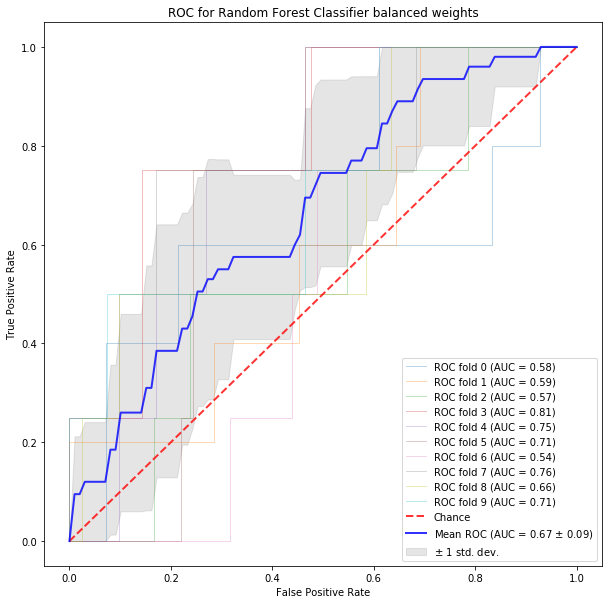

Accuracy mean:  0.778406824956



,Model title,Accuracy,Specificity,Recall(Sensitivity),Precision,F1,AUC,Generalized AUC
0,Logistic regression,0.907999,1.000000,0.000,0.000000,0.864231,0.559798,0.640367
1,Logistic regression balanced weights,0.609966,0.606388,0.655,0.141904,0.689548,0.669949,0.647706
2,Oversampling logistic regression,0.649155,0.649652,0.650,0.157159,0.721085,0.664697,0.678899
3,Oversampling logistic regression balanced weights,0.649155,0.649652,0.650,0.157159,0.721085,0.664697,0.678899
4,KNN,0.907999,1.000000,0.000,0.000000,0.864231,0.584603,0.810092
5,Oversampling KNN,0.575832,0.593612,0.395,0.092548,0.663198,0.555194,0.731193
6,SVM,0.907999,1.000000,0.000,0.000000,0.864231,0.715152,0.671560
7,SVM balanced weights,0.752265,0.763240,0.650,0.218323,0.799589,0.750354,0.563303
8,Oversampling SVM,0.811694,0.845412,0.485,0.241717,0.837325,0.744141,0.612844
9,Multilayer Perceptron,0.905634,0.980546,0.170,0.450000,0.883370,0.635214,0.394495


In [34]:
from sklearn import svm, datasets
from itertools import cycle
from scipy import interp
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
stats_columns = ["Model title", "Accuracy", "Specificity", "Recall(Sensitivity)", "Precision", "F1", "AUC", "Generalized AUC"]
#X = np.array(X)
#y = np.array(y)
cv = StratifiedKFold(n_splits=10)
cv_stats = []
X_fs, X_test, y_fs, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

#print(X_fs.head())

for item in models:
    # Run classifier with cross-validation and plot ROC curves
    print(item['title'])
    classifier = item['model']
    tprs = []
    aucs = []
    accs = []
    specificities = []
    recalls = []
    precisions = []
    f1s = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    cur_feature_set=item['feature_set']
    if(cur_feature_set == 'all'):
        X_cfs=np.array(X_fs)
        cur_feature_set= COLUMNS_TO_SCALE
    else:
        X_cfs=np.array(X_fs[cur_feature_set])
    y_fs = np.array(y_fs)
#     print(X_cfs.head())
    for train, test in cv.split(X_cfs, y_fs):
        probas_ = classifier.fit(X_cfs[train], y_fs[train]).predict_proba(X_cfs[test])
        predicts = classifier.predict(X_cfs[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_fs[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        conf_matrix = confusion_matrix(y_fs[test], predicts)
        roc_auc = auc(fpr, tpr)
        
        aucs.append(roc_auc)
        accs.append(accuracy_score(y_fs[test], predicts))
        specificities.append(float(conf_matrix[0][0]) / (conf_matrix[0][0] + conf_matrix[0][1]))
        recalls.append(recall_score(y_fs[test], predicts))
        precisions.append(precision_score(y_fs[test], predicts))
        f1s.append(f1_score(y_fs[test], predicts, average='weighted'))
        
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC for ' + item['title'])
    plt.legend(loc="lower right")
    plt.show()

    print("Accuracy mean: ",np.mean(accs))
    print()
    item['model'].fit(X_cfs, y_fs)
    y_pred_prob = item['model'].predict_proba(X_test[cur_feature_set])[:,1]
    test_after_auc = roc_auc_score(y_test, y_pred_prob)
    newRow = [item['title'],np.mean(accs), np.mean(specificities), np.mean(recalls), np.mean(precisions), np.mean(f1s), mean_auc, test_after_auc]
    cv_stats.append(newRow)
stats_df = pd.DataFrame(cv_stats, columns = stats_columns)
stats_df

# Hyper parameter optimisation

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV

class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [ ]:
# models = [
#           {'title':"Logistic regression", 'model':LogisticRegression(random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'key', 'duration']},
#           {'title':"Logistic regression balanced weights", 'model':LogisticRegression(class_weight='balanced', random_state=3), 'feature_set':['tempo', 'acousticness', 'danceability', 'valence']},
#           {'title':"Oversampling logistic regression", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
#           {'title':"Oversampling logistic regression balanced weights", 'model':make_pipeline_imb(SMOTE(random_state=4), LogisticRegression(class_weight='balanced',random_state=3)), 'feature_set':['tempo', 'acousticness', 'danceability', 'key', 'valence']},
#           {'title':"KNN", 'model':KNeighborsClassifier(n_neighbors = 17), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability']},
#           {'title':"Oversampling KNN", 'model':make_pipeline_imb(SMOTE(random_state=4), KNeighborsClassifier(n_neighbors = 17)), 'feature_set':['energy', 'instrumentalness', 'duration', 'valence', 'mode']},
#           {'title':"SVM", 'model':svm.SVC(probability=True, gamma='scale', random_state=3), 'feature_set':['liveness', 'tempo', 'acousticness', 'danceability', 'loudness', 'mode']},
#           {'title':"SVM balanced weights", 'model':svm.SVC(probability=True, gamma='scale', random_state=3, class_weight='balanced'), 'feature_set':['speechiness', 'key']},
#           {'title':"Oversampling SVM", 'model':make_pipeline_imb(SMOTE(random_state=4), svm.SVC(probability=True, gamma='scale', random_state=3)), 'feature_set':['tempo', 'time_signature']},
#           {'title':"Multilayer Perceptron", 'model':MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3), 'feature_set':['energy', 'acousticness', 'danceability', 'duration', 'valence', 'mode']},
#           {'title':"Oversampling Multilayer Perceptron", 'model':make_pipeline_imb(SMOTE(random_state=4), MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=3)), 'feature_set':['loudness', 'speechiness']},
#           {'title':"Random Forest Classifier balanced weights", 'model':RandomForestClassifier(n_estimators=100, max_depth=2, random_state=3, class_weight="balanced"), 'feature_set':['loudness', 'speechiness']}
#          ]

models1 = { 
    'Logistic regression': LogisticRegression(class_weight='balanced', random_state=3)
}

params1 = { 
    'Logistic regression': { 'solver' :['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
}

In [ ]:
helper1 = EstimatorSelectionHelper(models1, params1)
helper1.fit(X_fs, y_fs, scoring='roc_auc', n_jobs=10)
helper1.score_summary(sort_by='max_score')